In [1]:
import pandas as pd
from nltk import ngrams
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

### This is what we will proceed
- find unique `SrcAddr` and group by them
- apply sliding window inside them
- find ngrams(3-grams) in this sliding window

Please wait for about 3-5mins for this part

In [2]:
# reuse this module
from profiling import profile_scenario

selected_scenarios = [9, 10, 11, 12]

ip_ngrams_per_scene= {}
for scene in selected_scenarios:
    ip_ngrams_per_scene[scene] = profile_scenario('data/utils/discretized_scenario_'+str(scene)+'.csv')

100%|██████████| 23/23 [00:00<00:00, 382.76it/s]


In [3]:
import pickle
# read label encoder to convert encoded IPs to string

SrcAddr_LabelEncoder_per_scene= {}
for scene in selected_scenarios:
    SrcAddr_LabelEncoder_per_scene[scene] = pickle.load(open('./data/utils/SrcAddr_LabelEncoder_'+str(scene)+'.pkl', 'rb'))


try:
    for scene in selected_scenarios:
        keys = list(ip_ngrams_per_scene[scene].keys())
        ip_keys = list(SrcAddr_LabelEncoder_per_scene[scene].inverse_transform(keys))
        for i in range(len(ip_keys)):
            ip_ngrams_per_scene[scene][ip_keys[i]] = ip_ngrams_per_scene[scene].pop(keys[i])
finally:
    print('Labelled dictionary by IP and not discretised value :)')


Labelled dictionary by IP and not discretised value :)


We shall now be able find all profiles for a scenario by a particular IP. For example `ip_ngrams_per_scene[10]['147.32.80.9']` gives the profiles in all sliding windows of the machine with IP *147.32.80.9* in *scenario 10*

The infected IPs for every scenario are given in the respective README of the scenario 

In [4]:
# identify 1 infected IP  for training
train_infected_IPs_per_scene = {
    9: '147.32.84.165',
    10: '147.32.84.165',
    11: '147.32.84.165',
    12: '147.32.84.165'
}   

# identify other infected IPs for tuning the threshold
infected_IPs_per_scene = {
    9: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192',
        '147.32.84.193',
        '147.32.84.204',
        '147.32.84.205',
        '147.32.84.206',
        '147.32.84.207',
        '147.32.84.208',
        '147.32.84.209'
        ],

    10: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192',
        '147.32.84.193',
        '147.32.84.204',
        '147.32.84.205',
        '147.32.84.206',
        '147.32.84.207',
        '147.32.84.208',
        '147.32.84.209'
    ],

    11: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192'
    ],

    12: [
        # '147.32.84.165',
        '147.32.84.191',
        '147.32.84.192',
    ]
} 

# find all IPs for each scenario
all_IPs_per_scene = {
    9: list(ip_ngrams_per_scene[9].keys()),
    10: list(ip_ngrams_per_scene[10].keys()),
    11: list(ip_ngrams_per_scene[11].keys()),
    12: list(ip_ngrams_per_scene[12].keys()),
}

for scene in selected_scenarios:
    all_IPs_per_scene[scene].remove(train_infected_IPs_per_scene[scene])

### Compute cosine distances

In [5]:

from sklearn.metrics.pairwise import cosine_distances


def compute_cosine_distance(ip_ngrams:dict, train_IP:str, infedted_IPs:list, all_IPs:list):
    A = []  # set A: signatures for 1 infected IP 
    for signature in ip_ngrams[train_IP]:
        A.append(signature)

    true_labels = [] # labels for signatures 
    ip_distances = {}
    for ip in tqdm(all_IPs):
        if ip in infedted_IPs:
            true_labels.append(1)
        else:
            true_labels.append(0)

        sig_distances = []
        for signature in ip_ngrams[ip]:
            distances = []
            for a in A:
                distances.append(cosine_distances([a], [signature]))
            # print(distances)
            sig_distances.append(np.mean(distances))
        # print(sig_distances)
        ip_distances[ip] = sig_distances

    return ip_distances, true_labels

- For every scene find the signature distances from the known infected signatures.
- also derive the true labels for the IPs

In [6]:
# code for cosine similarity
# from profiling import compute_cosine_distance

RECOMPUTE_DISTANCES = False

if RECOMPUTE_DISTANCES:
    dist_per_scene = {}
    labels_per_scene = {}

    for scene in selected_scenarios:
        ip_distances, true_labels = compute_cosine_distance(
            ip_ngrams_per_scene[scene],
            train_infected_IPs_per_scene[scene],
            infected_IPs_per_scene[scene],
            all_IPs_per_scene[scene])

        dist_per_scene[scene] = ip_distances
        labels_per_scene[scene] = true_labels

    pickle.dump(dist_per_scene, open('data/utils/dist_per_scene.pkl', 'wb'))
    pickle.dump(labels_per_scene, open('data/utils/labels_per_scene.pkl', 'wb'))

100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


In [7]:
# read saved distances and labels
dist_per_scene = pickle.load(open('data/utils/dist_per_scene.pkl', 'rb'))
labels_per_scene = pickle.load(open('data/utils/labels_per_scene.pkl', 'rb'))

We need to clean out some IPs because they did not have enough records enabling **(sliding window + n-gram)** combination

In [8]:
# clean labels
for scene in selected_scenarios:
    for ip in infected_IPs_per_scene[scene]:
        if ip not in list(dist_per_scene[scene].keys()):
            infected_IPs_per_scene[scene].remove(ip)

    if ip in all_IPs_per_scene[scene]:
        if ip not in list(dist_per_scene[scene].keys()):
            all_IPs_per_scene[scene].remove(ip)

### Plotting fucntion 
Now we will plot the data for each scenario to select the threshold

In [38]:
def plot(ip_distance_mean_std:dict, infected_IPs:list, all_IPs, title:str, threshold=None):
    # lets Plot the resulting decision boundary
    fig, ax = plt.subplots(1,1, figsize=(14,5))
    ax.set_xscale('log')
    ax.set_xlabel('distance (log-scale)')
    ax.set_ylim((-0.1,0.1))
    values = np.array(list(ip_distance_mean_std.values()))
    # print(values)
    # X = values
    # y = np.zeros((values.shape[0]))
    # # ax.scatter(X, y, label='means') # plot means
    # size = 250
    
    x = np.array([])
    for ip in infected_IPs:
        dists = np.array(ip_distance_mean_std[ip])
        x = np.concatenate([x, dists])
    x = np.array(x)
    print(x.shape)
    ax.scatter(x, np.zeros(len(x)), c='r', alpha=0.1, label='known botnet')
    
    x = np.array([])
    for ip in all_IPs:
        if ip not in infected_IPs:
            dists = np.array(ip_distance_mean_std[ip])
            x = np.concatenate([x, dists])
    ax.scatter(x, np.zeros(len(x)), c='g', alpha=0.1, label='known normal')

    if threshold is not None:
        ax.axvline(threshold, ymin=-0, ymax=1, label='threshold', linestyle='--')
    
    # ax.set_xticks(range(1,10,1))
    ax.legend()
    plt.show()

### Threshold selection
- We made the plots without the decision boundary i.e. just the means with label markers (red, green)
- We decided the thresholds
- then we plotted the one with the decision boundary **(what you see below)**

***NO magic numbers***

In [39]:
# x=[]
# for ip in all_IPs_per_scene[9]:
#     print(dist_per_scene[9][ip])

(6475,)


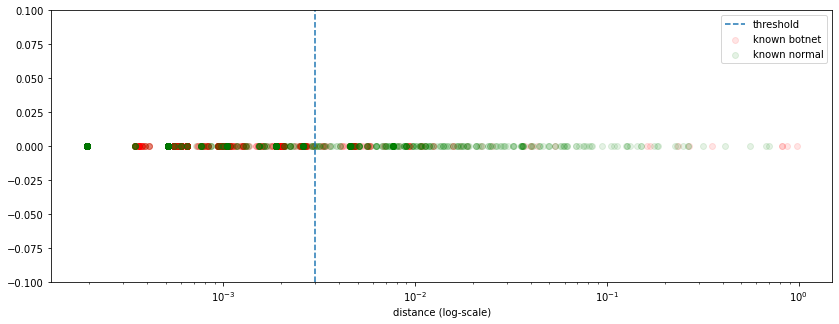

(3857,)


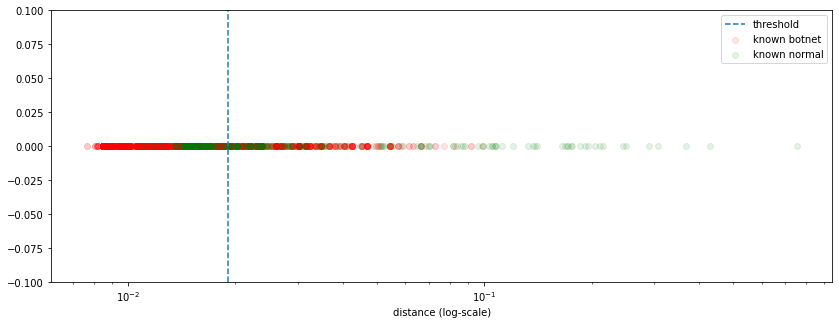

(159,)


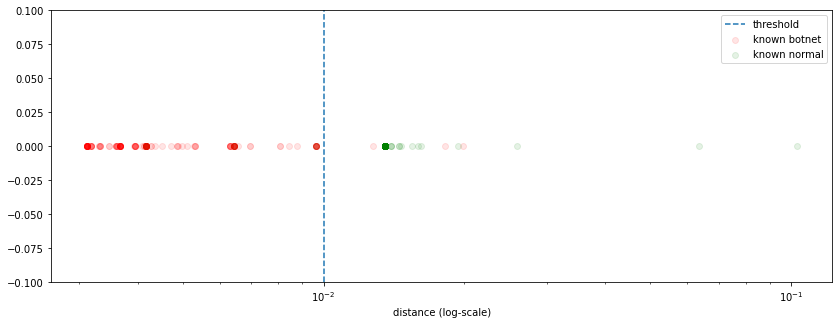

(50,)


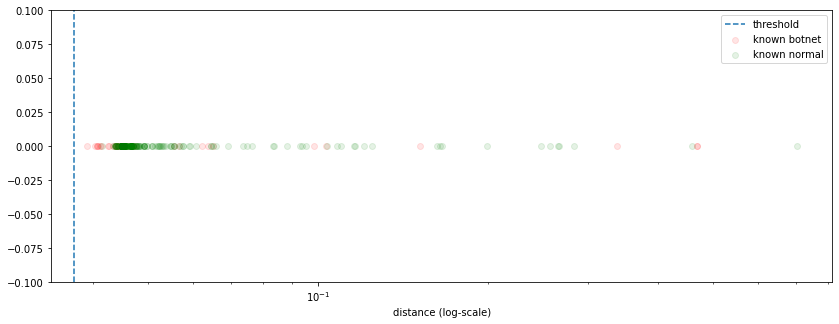

In [40]:
thresholds_per_scene = {
    9:  3e-3,
    10: 1.9e-2,
    11: 1e-2,
    12: 3.7e-2,
}

for scene in selected_scenarios:
    plot(dist_per_scene[scene],
         infected_IPs_per_scene[scene], 
         all_IPs_per_scene[scene], 
         'Scenario '+str(scene), 
         thresholds_per_scene[scene])

### Lets make predictions

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

def predict(ip_distance_mean_std:dict, threshold:float):
    pred = []
    values = np.array(list(ip_distance_mean_std.values()))
    for value in values:
        if value[0] <= threshold:
            pred.append(1)
        else:
            pred.append(0)
    return pred

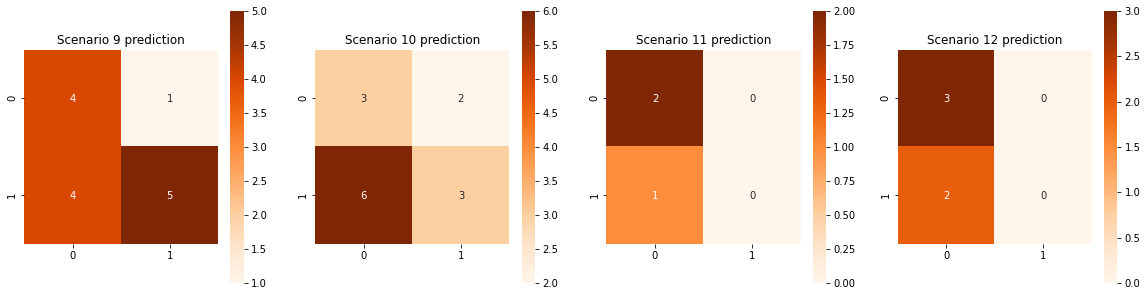

In [13]:
fig, axs = plt.subplots(1, 4)
fig.set_size_inches((20,5))
for i in range(4):
    scene = selected_scenarios[i]
    pred = predict(dist_per_scene[scene], thresholds_per_scene[scene])
    conf = confusion_matrix(labels_per_scene[scene], pred)
    axs[i].set_title('Scenario ' + str(scene)+' prediction')
    sns.heatmap(conf, square=True, annot=True, cmap=plt.cm.Oranges, ax = axs[i])